## Import necessary libraries

In [1]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from keras.callbacks import Callback
from keras.utils import array_to_img
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling1D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model

# Enabling GPU for boosting speed
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.reset_memory_stats(gpu, True)
tf.config.run_functions_eagerly(True)
# Disable unwanted warning
import warnings
warnings.filterwarnings('ignore')

## Import the data
The data is hourly-based generation of PV device in watt for one year which is provided by PVWattCalculator.
The data is for a specific location and the aforementioned tool considers all factors affecting pv generation, including temperature,  pressure, irradiance, device specifications, .... The data is provided as average. We are interested in generating a profile of PV generation in a representative day of each month, for example January.
The task is generating profiles that are as close as, or as similar as, the provided data.


In [33]:
pv_year = pd.read_csv('hourly.csv')[['Month', 'Day', 'Hour', 'DC Output (W)']]
months = {1:'Jan', 2:'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# Separating months from the annual data
for m in months.keys():

    # At each iteration, one month is separated
    mask = pv_year['Month'] == m
    each_month = {}
    for d in range(int(len(pv_year[mask]['DC Output (W)'])/24)):
        each_month[d] = np.divide(pv_year[mask]['DC Output (W)'].iloc[d*24:(d+1)*24].values, 1000)

    # As data for one month is not sufficient for training, we oversample using mean method.
    # Cahnge new_samples which is the number of samples to be generated and added to data.
    new_samples = 10
    if new_samples != 0:
        for index in range(new_samples):
            s = random.sample(each_month.keys(), 2)
            each_month[f'g{index}'] = np.mean([each_month[s[0]], each_month[s[1]]], axis=0)

    # Save separated and new generated data for training
    pd.DataFrame(each_month).to_csv(f'PV-{months[m]}.csv', index=False)

## Select a month and Prepare data to feed into GAN
It need to be specified for which month you want to generate profiles. Here, we work on September. Feel free to change it into other desired months.

In [121]:
month_name='Sep'
ds_table = pd.read_csv(f'PV-{month_name}.csv')

# turn the whole data into a list to later turn into Tensor format
# We need to standardize the data. GAN works better with data that is standardized. To do so, we use min-max scaling.
# We need to save min and max of data for later transformation to true value.
ds = np.array([ds_table[c].values for c in ds_table.columns])
ds_max = np.max(ds)
ds_n = np.divide(ds, ds_max)

To prepare data for GAN, we need to turn it into Tensors, define batch size, shuffle data to remove order, turn data into bathces, and move data into a cache before it is needed, which can help reduce the time it takes to retrieve data from memory.

In [122]:
ds = tf.data.Dataset.from_tensor_slices(ds)
array_size = 24
batch_size = 8
ds = ds.cache()
ds = ds.shuffle(1000)
ds = ds.batch(batch_size)
ds = ds.prefetch(64)

## Building Generator DNN

In [170]:
g_relu = 0.2 # the parameter for relu activation function
def build_generator():
    model = Sequential()

    model.add(Dense(1*array_size*batch_size, input_dim=batch_size)) # each sample is a array of size 1*24, so input dimension has length 24
    model.add(LeakyReLU(g_relu))
    model.add(Reshape((1,array_size, batch_size)))

    # First Conv2D layer
    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    # Second Conv2D layer
    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    # Third Conv2D layer
    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    # Fourth Conv2D layer
    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    # Fiveth Conv2D to turn it into one sequence
    model.add(Conv2D(1, 3, padding='same', activation='sigmoid'))
    model.add(Flatten())
    return model

generator = build_generator()
# Activate below code to see the summary if GAN network
generator.summary()

# Test Generator with random data
series = generator.predict(np.random.randn(8, 8, 1)) #(number of samples to generate, batch size,


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 192)            │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_185 (LeakyReLU)     │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_31 (Reshape)            │ (None, 1, 24, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 1, 24, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_186 (LeakyReLU)     │ (None, 1, 24, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 1, 24, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_187 (LeakyReLU)     │ (None, 1, 24, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 1, 24, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_188 (LeakyReLU)     │ (None, 1, 24, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 1, 24, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_189 (LeakyReLU)     │ (None, 1, 24, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 1, 24, 1)       │            73 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 24)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,137 (16.16 KB)

 Trainable params: 4,137 (16.16 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


## Building Discriminator DNN

In [172]:
d_relu = 0.2 # the parameter for relu activation function
d_dropout = 0.2 # This is to avoid over fitting by dropping out neurons during training
def build_discriminator():
    model = Sequential()

    model.add(Dense(200, input_shape=(24, 1)))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Dense(150))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Flatten())
    model.add(Dropout(d_dropout))
    model.add(Dense(1, activation='sigmoid'))
    # 1: fake series, 0: real series

    return model
discriminator = build_discriminator()
discriminator.summary()
# Single prediction needs np.expand_dims(series[0], 0)
#discriminator.predict(np.expand_dims(series[0], 0))

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 24, 200)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_192 (LeakyReLU)     │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 24, 150)        │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_193 (LeakyReLU)     │ (None, 24, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 24, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1)              │         3,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,151 (133.40 KB)

 Trainable params: 34,151 (133.40 KB)

 Non-trainable params: 0 (0.00 B)

## Determine parameters, optimizer for loss, and type pf loss calculation, and define GAN

In [173]:
g_a, d_a = 0.0001, 0.00001  # generator must learn faster than discriminator to beat it up.
g_opt = Adam(learning_rate=g_a)
d_opt = Adam(learning_rate=d_a)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # pass through and add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
loadgan = LoadGAN(generator, discriminator)
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

## Start Training with the training data

In [179]:
hist = loadgan.fit(ds, epochs=50)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - d_loss: 0.6451 - g_loss: 0.7146
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - d_loss: 0.6442 - g_loss: 0.7152
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 0.6402 - g_loss: 0.7160
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - d_loss: 0.6417 - g_loss: 0.7166
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - d_loss: 0.6415 - g_loss: 0.7172
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 0.6469 - g_loss: 0.7179
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 0.6381 - g_loss: 0.7185
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - d_loss: 0.6387 - g_loss: 0.7192
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 0.6334 - g_loss: 0.7199
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - d_loss: 0.6336 - g_loss: 0.7206
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - d_loss: 0.6366 - g_loss: 0.7211
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - d_loss: 0.6324 - g_lo

## Generate profiles using the trained G and D

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


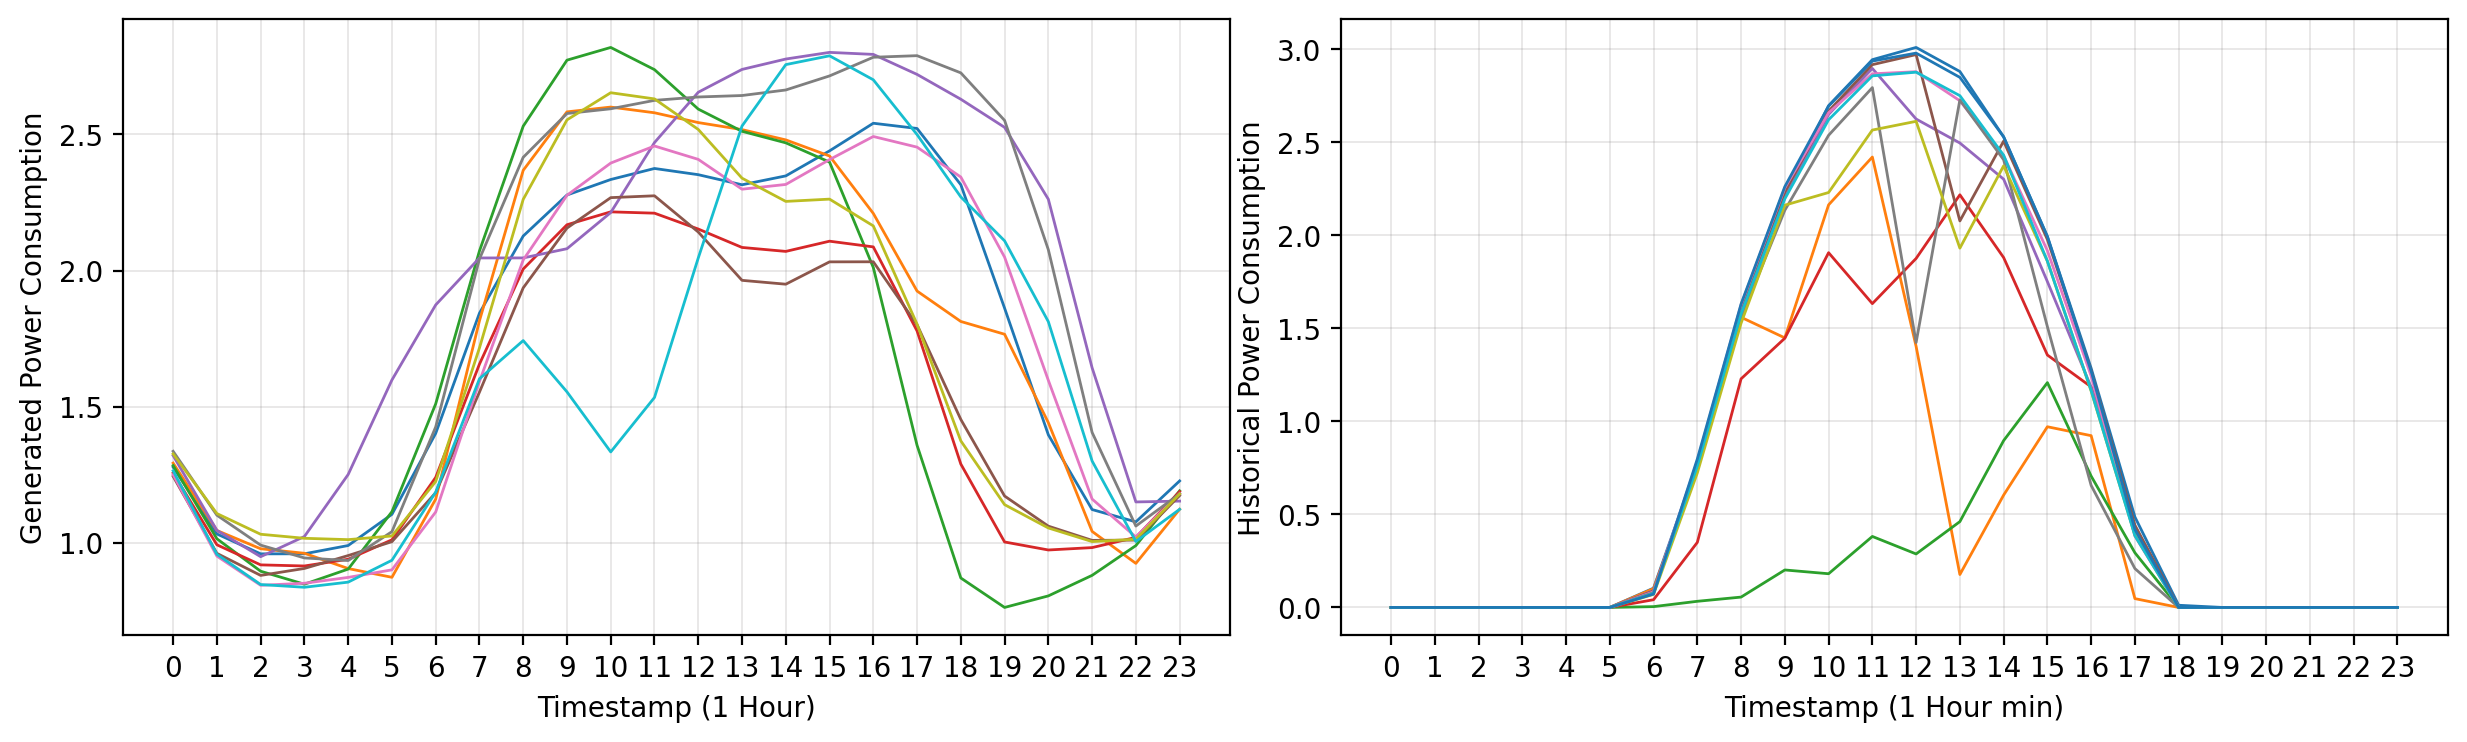

In [181]:
scenario_size = 20 # define desired number of scenarios
normal_noise = tf.random.normal((scenario_size, batch_size, 1)) # generate some normal noise
n = [np.random.normal() for _ in range(scenario_size)]
scenarios = np.multiply(generator.predict(normal_noise), ds_max)
resolution = 24

# This part calculates the probability for each scenario
probabilities = []
ranges = np.linspace(-3.5, 3.5, 8) # range of normal distribution divided into 8 sections
intervals = np.linspace(-3, 3, 7)  # representative value for each section
probs = [stats.norm.cdf(i) for i in n]
prob_ranges = {intervals[i]: [stats.norm.cdf(ranges[i]), stats.norm.cdf(ranges[i+1])] for i in range(len(intervals))}
for i in probs:
    for key in intervals:
        if prob_ranges[key][0]<= i <=prob_ranges[key][1]:
            probabilities.append(prob_ranges[key][1]-prob_ranges[key][0])
            break

scenario_dict = {'probs': probabilities}
for j in range(resolution):
    scenario_dict[j] = []

for i in range(scenario_size):
    s = scenarios[i].reshape([resolution])
    for j in range(resolution):
        scenario_dict[j].append(s[j])
pd.DataFrame(scenario_dict).to_csv(f'PVscenario-{month_name}.csv') # Save scenarios for the corresponding month


ticks = [i for i in range(resolution)]
fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
for s in scenarios[:10]:
    ax[0].plot(range(resolution), s.reshape([resolution]), linewidth=1)

ax[0].set_xlabel('Timestamp (1 Hour)')
ax[0].set_ylabel('Generated Power Consumption')
ax[0].set_xticks(ticks, ticks)
ax[0].grid(color='#666362', linestyle='-', linewidth=0.1)

ax[1].plot(ds_table[[c for c in ds_table.columns][4:15]], linewidth=1)
ax[1].set_xlabel('Timestamp (1 Hour min)')
ax[1].set_ylabel('Historical Power Consumption')
ax[1].set_xticks(ticks, ticks)
ax[1].grid(color='#666362', linestyle='-', linewidth=0.1)
plt.subplots_adjust(wspace=0.1)
#plt.savefig(f'PV GAN {month_name}.jpg', bbox_inches='tight')

## Track Generator and Discriminator loss
We expect generator loss reduce over epochs an discriminator loss increase. Here, we can observe such behavior.
In case the otherwise is observed, parameter tuning and modifying the structure of the DNNs are recommended.

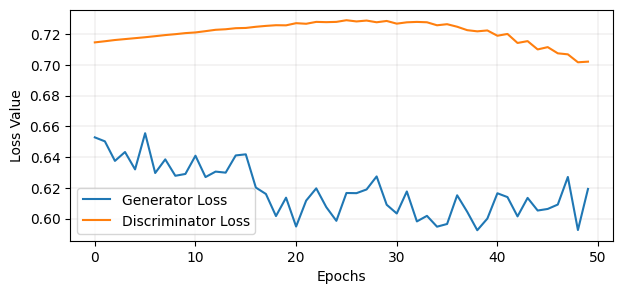

In [184]:
plt.figure(figsize=(7, 3))
plt.plot(hist.history['d_loss'], label='Generator Loss')
plt.plot(hist.history['g_loss'], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(color='#666362', linestyle='-', linewidth=0.1)
